In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the CSV file 

url = 'https://raw.githubusercontent.com/juancaros/IEDIS/refs/heads/main/Bizi/Usos%20Oct16-Mar17%201.csv'
df = pd.read_csv(url, sep=';')

print(df.columns)

Index(['IDUsuario', 'RetiroDT', 'RetiroEstacion', 'AnclajeDT',
       'AnclajeEstacion'],
      dtype='object')


Numero max de trayectos: 925


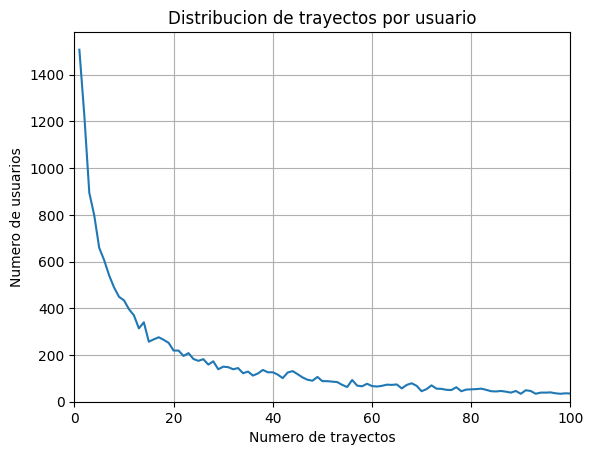

In [3]:
# Plot histogram of trajets per user

nbr_trajet = df["IDUsuario"].value_counts()

print('Numero max de trayectos:', nbr_trajet.max())

freq = nbr_trajet.value_counts().sort_index()   # index = number_of_trips, value = number_of_users

plt.figure()
plt.plot(freq.index, freq.values)
plt.xlabel('Numero de trayectos')
plt.ylabel('Numero de usuarios')
plt.title('Distribucion de trayectos por usuario')
plt.xlim(0, 100)
plt.ylim(0)
plt.grid(True)
plt.show()

In [4]:
# Get the year, the month and the day from RetiroDT

df['RetiroDT'] = pd.to_datetime(df['RetiroDT'], errors='coerce') # errors='coerce' turns unparsable values into NaT (missing)

# Converting to UTC (in order to compare with Conception)
df['RetiroDT'] = df['RetiroDT'].dt.tz_localize('Europe/Madrid').dt.tz_convert('UTC')

df['Retiro_year'] = df['RetiroDT'].dt.year
df['Retiro_month'] = df['RetiroDT'].dt.month
df['Retiro_day'] = df['RetiroDT'].dt.weekday # Monday=0, Sunday=6

print(df['Retiro_year'].unique())

[2016.   nan 2017.]


Numero de trayectos max en 2016: 454 por el usuario 64463.0
Numero de trayectos max en 2017: 484 por el usuario 84686.0


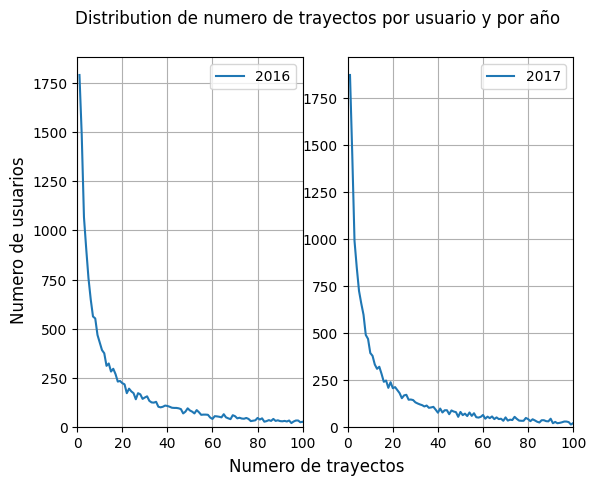

In [5]:
#Plot histogram of trajets per user per year

mask_2016 = df['Retiro_year'] == 2016
nbr_trajet_2016 = df.loc[mask_2016, 'IDUsuario'].value_counts()
freq_2016 = nbr_trajet_2016.value_counts().sort_index()   # index = number_of_trips, value = number_of_users
print('Numero de trayectos max en 2016:', nbr_trajet_2016.max(), "por el usuario", nbr_trajet_2016.idxmax())

mask_2017 = df['Retiro_year'] == 2017
nbr_trajet_2017 = df.loc[mask_2017, 'IDUsuario'].value_counts()
freq_2017 = nbr_trajet_2017.value_counts().sort_index()   # index = number_of_trips, value = number_of_users
print('Numero de trayectos max en 2017:', nbr_trajet_2017.max(), "por el usuario", nbr_trajet_2017.idxmax())


x_lim = 100

fig, ax = plt.subplots(1, 2)

ax[0].plot(freq_2016.index, freq_2016.values, label='2016')
ax[0].set_xlim(0, x_lim)
ax[0].set_ylim(0)
ax[0].grid(True)
ax[0].legend()

ax[1].plot(freq_2017.index, freq_2017.values, label='2017')
ax[1].set_xlim(0, x_lim)
ax[1].set_ylim(0)
ax[1].grid(True)
ax[1].legend()

fig.supxlabel('Numero de trayectos')
fig.supylabel('Numero de usuarios')
fig.suptitle('Distribution de numero de trayectos por usuario y por año')
plt.show()

In [6]:
# Creat a new column to know if the day is weekend (1) or not (0)
#Suppose that the bike is taken and returned the same day

def define_weekend(day):
    if day >= 5:
        return 1
    else:
        return 0
    
df['is_weekend'] = df['Retiro_day'].apply(define_weekend)


# Calculate the percentage of trajets on weekend and on weekdays
weekend_counts = df['is_weekend'].value_counts(normalize=True) * 100

print(f'Percentage of trajets on weekend: {weekend_counts.values[1]:.2f} %')
print(f'Percentage of trajets on weekdays: {weekend_counts.values[0]:.2f} %')

Percentage of trajets on weekend: 14.92 %
Percentage of trajets on weekdays: 85.08 %


In [7]:
#Calculate the time difference between RetiroDT and AnclajeDT in minutes

df['AnclajeDT'] = pd.to_datetime(df['AnclajeDT'], errors='coerce')

# Converting to UTC (in order to compare with Conception)
df['AnclajeDT'] = df['AnclajeDT'].dt.tz_localize('Europe/Madrid').dt.tz_convert('UTC')

df['time_diff'] = (df['AnclajeDT'] - df['RetiroDT']).dt.seconds / 60 

In [8]:
#Calculate the pourcentage of trajets in different time bins

# Define bin edges and labels
bins = [0, 5, 15, 30, 60, 120, np.inf]
labels = ['<5', '5-15', '15-30', '30-60', '60-120', '>=120']

# Bin the time_diff values
df['duration_bin'] = pd.cut(df['time_diff'], bins=bins, labels=labels, right=False)

# Count occurrences in each bin
duration_counts = df['duration_bin'].value_counts(normalize=True)

# Print results
for label in labels:
    print(f"Numero de trayectos con duracion {label}: {duration_counts[label]:.2f}")


Numero de trayectos con duracion <5: 0.11
Numero de trayectos con duracion 5-15: 0.69
Numero de trayectos con duracion 15-30: 0.17
Numero de trayectos con duracion 30-60: 0.01
Numero de trayectos con duracion 60-120: 0.00
Numero de trayectos con duracion >=120: 0.01


In [ ]:
#pip install geopandas

                                            geometry   TIPO_DIRECCIONALIDAD  \
0  MULTILINESTRING ((-1.03748 41.72343, -1.03716 ...   Carril bidireccional   
1  MULTILINESTRING ((-1.02463 41.72105, -1.02445 ...   Carril bidireccional   
2  MULTILINESTRING ((-0.9579 41.6234, -0.95788 41...  Carril unidireccional   
3  MULTILINESTRING ((-0.94073 41.63214, -0.94076 ...         Carril calmado   
4  MULTILINESTRING ((-0.93111 41.62904, -0.93112 ...         Carril calmado   

  TIPO_CARRIL  
0           3  
1           3  
2           8  
3           4  
4           4  


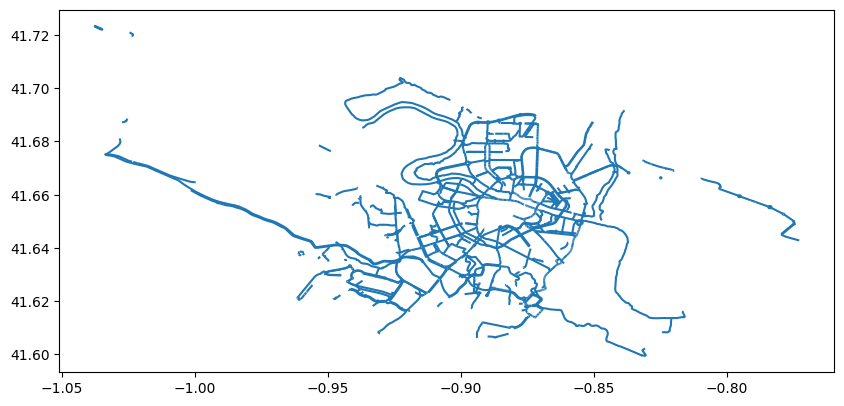

In [9]:
import geopandas as gpd
import json

# Cargar tu JSON
with open('Public/carriles_WGS84.json', 'r') as f:
    data = json.load(f)

# Convertir a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data['features'])

# Ver los datos
print(gdf.head())

# Visualizar mapa simple
gdf.plot(figsize=(10, 10))

# Calcular longitud de cada carril (en grados, luego puedes convertir a metros)
gdf['longitud_km'] = gdf.geometry.length * 111  # aprox km